In [1]:
import jax.numpy as jnp

In [18]:
def build_rope_cache(seq_len, dim, freq=10000):
    # [1, D // 2]
    inv_freq = 1 / freq ** (jnp.arange(0, dim, 2) / dim)[None, :]

    # [S, 1]
    pos = jnp.arange(0, seq_len)[:, None]

    # [S, D//2]
    m_theta = inv_freq * pos

    # [S, D]
    cos, sin = jnp.cos(m_theta), jnp.sin(m_theta)
    return cos, sin

def apply_rope(x, cos, sin):
    bsz, seq_len, dim = x.shape
    # For broadcasting the batch dimension
    cos = cos[None, :, :]
    sin = sin[None, :, :]

    x_odd = x[..., 1::2]
    x_even = x[..., 0::2]

    x_rot_odd = cos * x_odd + sin * x_even
    x_rot_even = cos * x_even - sin * x_odd

    x_rot = jnp.empty_like(x)
    x_rot = x_rot.at[..., 0::2].set(x_rot_even)
    x_rot = x_rot.at[..., 1::2].set(x_rot_odd)

    return x_rot

max_seq_len = 128
dim = 64
cos, sin = build_rope_cache(max_seq_len, dim)

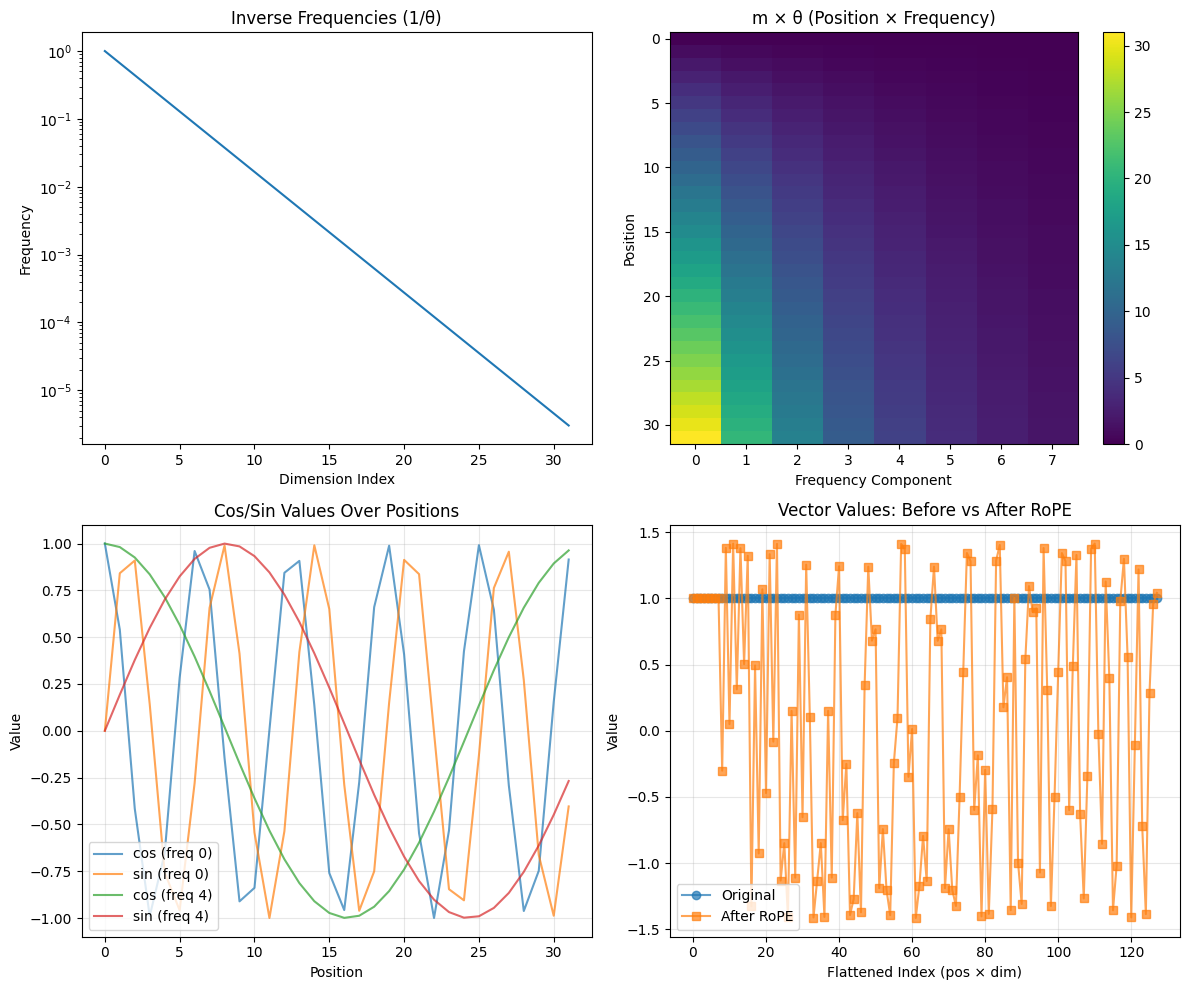

RoPE Analysis:
Frequency range: 1.000000 to 0.000003
Period range: 2084764.88 to 6.28 positions
At position 64, phase range: 0.000 to 64.000 radians


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the frequency components and their effects
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Visualize the inverse frequencies
freqs = 1 / (500000 ** (jnp.arange(0, dim, 2) / dim))
axes[0, 0].plot(freqs)
axes[0, 0].set_title('Inverse Frequencies (1/θ)')
axes[0, 0].set_xlabel('Dimension Index')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')

# 2. Visualize m * theta for different positions and dimensions
pos_range = jnp.arange(0, 32)  # First 32 positions
m_theta_sample = jnp.outer(pos_range, freqs[:8])  # First 8 frequency components
im1 = axes[0, 1].imshow(m_theta_sample, aspect='auto', cmap='viridis')
axes[0, 1].set_title('m × θ (Position × Frequency)')
axes[0, 1].set_xlabel('Frequency Component')
axes[0, 1].set_ylabel('Position')
plt.colorbar(im1, ax=axes[0, 1])

# 3. Visualize cos and sin values over positions for different frequencies
axes[1, 0].plot(pos_range, jnp.cos(m_theta_sample[:, 0]), label='cos (freq 0)', alpha=0.7)
axes[1, 0].plot(pos_range, jnp.sin(m_theta_sample[:, 0]), label='sin (freq 0)', alpha=0.7)
axes[1, 0].plot(pos_range, jnp.cos(m_theta_sample[:, 4]), label='cos (freq 4)', alpha=0.7)
axes[1, 0].plot(pos_range, jnp.sin(m_theta_sample[:, 4]), label='sin (freq 4)', alpha=0.7)
axes[1, 0].set_title('Cos/Sin Values Over Positions')
axes[1, 0].set_xlabel('Position')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Show how rope affects a sample vector
sample_x = jnp.ones((1, 16, dim))  # Sample input
x_rotated = apply_rope(sample_x, cos[:16], sin[:16])

# Compare original vs rotated for first few dimensions
dims_to_show = 8
axes[1, 1].plot(sample_x[0, :, :dims_to_show].flatten(), 'o-', label='Original', alpha=0.7)
axes[1, 1].plot(x_rotated[0, :, :dims_to_show].flatten(), 's-', label='After RoPE', alpha=0.7)
axes[1, 1].set_title('Vector Values: Before vs After RoPE')
axes[1, 1].set_xlabel('Flattened Index (pos × dim)')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Show how different frequencies affect rotation at different positions
print("RoPE Analysis:")
print(f"Frequency range: {freqs[0]:.6f} to {freqs[-1]:.6f}")
print(f"Period range: {2*np.pi/freqs[-1]:.2f} to {2*np.pi/freqs[0]:.2f} positions")
print(f"At position 64, phase range: {64*freqs[-1]:.3f} to {64*freqs[0]:.3f} radians")


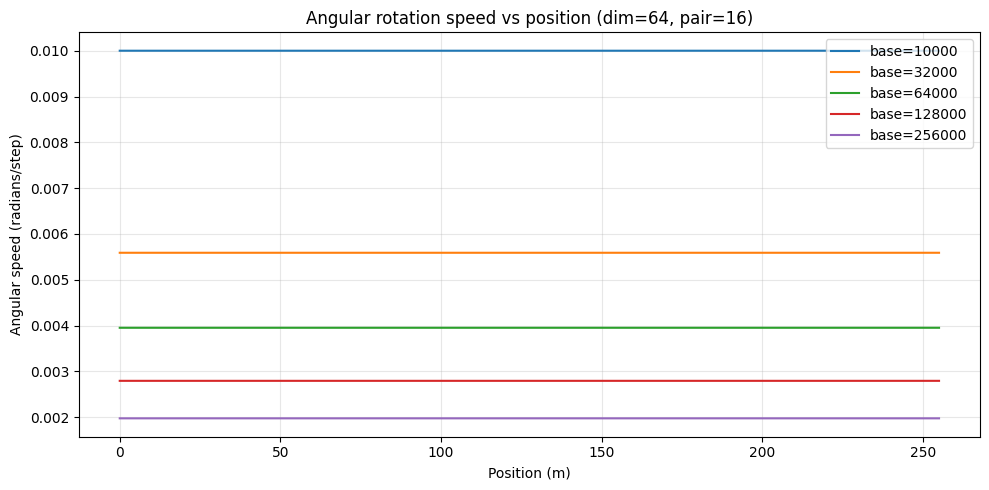

Theoretical speeds (radians/step):
  base= 10000: 1.000000e-02
  base= 32000: 5.590170e-03
  base= 64000: 3.952847e-03
  base=128000: 2.795085e-03
  base=256000: 1.976424e-03


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Variant: show base-dependent differences using a higher pair index (k > 0)
bases = [10_000, 32_000, 64_000, 128_000, 256_000]
seq_len = 256
dim = 64
pair_idx = 16  # choose a mid/high-frequency pair; 0 <= pair_idx < dim//2

assert 0 <= pair_idx < dim // 2

# Build a vector that is nonzero only in the chosen pair (2k, 2k+1)
v = jnp.zeros((dim,), dtype=jnp.float32)
v = v.at[2 * pair_idx].set(1.0)   # x component
v = v.at[2 * pair_idx + 1].set(0.0)  # y component

# Repeat across positions to form [1, S, D]
x = jnp.repeat(v[None, None, :], repeats=seq_len, axis=1)

plt.figure(figsize=(10, 5))
for base in bases:
    cos, sin = build_rope_cache(seq_len, dim, freq=base)
    x_rot = apply_rope(x, cos, sin)
    xs = np.asarray(x_rot[0, :, 2 * pair_idx])
    ys = np.asarray(x_rot[0, :, 2 * pair_idx + 1])
    angles = np.arctan2(ys, xs)
    angles_unwrapped = np.unwrap(angles)
    speed = np.gradient(angles_unwrapped)
    plt.plot(speed, label=f'base={base}')

plt.title(f'Angular rotation speed vs position (dim={dim}, pair={pair_idx})')
plt.xlabel('Position (m)')
plt.ylabel('Angular speed (radians/step)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Theoretical speeds for reference: inv_freq[k] = base**(-2k/d)
print('Theoretical speeds (radians/step):')
for base in bases:
    expected = float(1.0 / (base ** (2.0 * pair_idx / dim)))
    print(f'  base={base:6d}: {expected:.6e}')

